# Setup

In [43]:
from pymonntorch import *
import numpy as np
import torch
from matplotlib import pyplot as plt
import random
import math

# InputCurrent

In [845]:
class CurrentBehavior(Behavior) : 
    
    def initialize(self, neuron) :
        super().initialize(neuron)
        
        neuron.I = neuron.vector("zeros")
        
        self.pw = self.parameter("pw", 20)
        self.has_noise = self.parameter("has_noise", False)
        self.mode = self.parameter("mode", "constant")
        self.iter = 1
        self.func = self.parameter("custom", None)
        
        if(self.mode == "constant") : 
            def constant_curr(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                return (cnt > 0) * (self.pw + self.has_noise * (random.random() * self.pw - self.pw/2 * x) / 2)
            
            self.func = constant_curr
        
        elif(self.mode == "trigeometric") : 
            def trigeometric_curr(cnt) : 
                return (math.sin(cnt/360 * np.pi))**2 * self.pw + self.has_noise * (random.random() * self.pw - random.random() * 1.5*self.pw)
            
            self.func = trigeometric_curr

        elif(self.mode == "random") : 
            def random_curr(cnt) : 
                a, res, state = np.random.rand(5) * self.pw, 0, 1
                for i in a : 
                    res += state * i
                    state *= -1
                return res
            
            self.func = random_curr
        
        elif(self.mode == "step") : 
            def step_curr(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                return ((cnt > 1 and cnt < 40)) * (self.pw + self.has_noise * (random.random() * self.pw - self.pw/2 * x) / 2)
            
            self.func = step_curr

        elif(self.mode == "stair") : 
            def stair(cnt) : 
                return neuron.I + self.pw
            
            self.func = stair

        elif(self.mode == "change") : 
            def ch(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                return (cnt > 0) * (self.pw + self.has_noise * (random.random() * self.pw/8 - self.pw/16 * x) / 2) + (cnt > 50) * (self.pw / 2) 
            self.func = ch

        elif(self.mode == "change2") : 
            def ch2(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                return (cnt > 1) * (self.pw + self.has_noise * (random.random() * self.pw/8 - self.pw/16 * x) / 2) - (cnt > 100) * (self.pw / (0.01 + 201 - cnt)) 
            self.func = ch2

        elif(self.mode == "swap1") : 
            def ch(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                res = (cnt > 0) * (self.pw + self.has_noise * (random.random() * self.pw/8 - self.pw/16 * x) / 2) + (cnt > 50 and cnt < 100) * (self.pw / 2) 
                return res
            self.func = ch

        elif(self.mode == "swap2") : 
            def ch(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                res = (cnt > 0) * (self.pw + self.has_noise * (random.random() * self.pw/8 - self.pw/16 * x) / 2) + (cnt > 120) * (self.pw / 2) 
                return res
                
            self.func = ch

        else :
            self.func = self.parameter("custom", None)


    def forward(self, neuron) : 
        neuron.I += (self.func(self.iter) - neuron.I)
        self.iter += 1

# LIF

In [670]:
class LIF_Behavior(Behavior) :

    def initialize(self, ng) : 
        super().initialize(ng)

        self.threshold = self.parameter("threshold", -10)
        self.reset = self.parameter("reset", -80)
        self.rest = self.parameter("rest", -65)
        self.tau = self.parameter("tau", 10)
        self.dt = self.parameter("dt", 1)
        self.R = self.parameter("R", 10)

        ng.voltage = ng.vector("normal(-60, 40)")

        firing = ng.voltage >= self.threshold
        ng.spike = firing.byte()
        ng.voltage[firing] = self.reset

        ng.activity = ng.vector(torch.sum(ng.spike).item()) / ng.size


    def forward(self, ng) : 
        firing = ng.voltage >= self.threshold
        ng.spike = firing.byte()
        ng.voltage[firing] = self.reset

        dV = (-(ng.voltage - self.rest) + self.R * ng.I) / self.tau 
        ng.voltage += dV * self.dt

        ng.activity = ng.vector(torch.sum(ng.spike).item()) / ng.size
        

# AELIF

In [92]:
class AELIF_Behavior(Behavior) : 

    def initialize(self, neuron) : 
        super().initialize(neuron)

        # main LIF
        # -----------------------------------------------------------

        self.threshold = self.parameter("threshold", 30)
        neuron.reset = self.parameter("reset", -80)
        neuron.rest = self.parameter("rest", -65)
        neuron.tau = self.parameter("tau", 10)
        neuron.dt = self.parameter("dt", 1)
        neuron.R = self.parameter("R", 10)

        neuron.voltage = neuron.vector("normal(-65, 15)")

        # Exponential parameters

        self.rh_threshold = self.parameter("rh_threshold", -10)
        neuron.delta = self.parameter("delta", 5)

        neuron.spike_zone = False

        # Adaptability
        # -----------------------------------------------------------
        
        neuron.a = self.parameter("a", 0.2) # sub-threshold adaptation variable
        neuron.b = self.parameter("b", 0.7) # spike-triggered adaptation variable

        neuron.w = 0 # adaptive variable
        neuron.adpt_tau = self.parameter("adpt_tau", 10) # time-constant for w

    def forward(self, neuron) : 
        firing = torch.BoolTensor([(neuron.voltage >= self.rh_threshold and not neuron.spike_zone)])
            
        if(firing) : 
            neuron.spike_zone = True
        elif(not firing and neuron.voltage < self.rh_threshold) :
            neuron.spike_zone = False
        
        neuron.spike = firing.byte()
            
        reset_need = neuron.voltage >= self.threshold
        neuron.voltage[reset_need] = neuron.reset

        dV = (
            -(neuron.voltage - neuron.rest) * (not neuron.spike_zone)
            + neuron.delta*torch.exp(torch.tensor([(neuron.voltage - self.rh_threshold) / neuron.delta]))
            + neuron.R*neuron.I 
            - neuron.R*neuron.w * (not neuron.spike_zone)
        ) / neuron.tau
        
        neuron.voltage += dV * neuron.dt

        dW = (
            + neuron.a*(neuron.voltage - neuron.rest)
            - neuron.w
            + neuron.b*neuron.adpt_tau*(firing.byte())
        ) / neuron.adpt_tau

        neuron.w += dW * neuron.dt

In [253]:
class Adaptive_RAELIF(Behavior) :
    
    def initialize(self, neuron) : 
        super().initialize(neuron)

        # main LIF
        # -----------------------------------------------------------
        neuron.threshold = self.parameter("threshold", 30)
        neuron.reset = self.parameter("reset", -120)
        neuron.rest = self.parameter("rest", -65)
        neuron.tau = self.parameter("tau", 10)
        neuron.dt = self.parameter("dt", 1)
        neuron.R = self.parameter("R", 10)

        neuron.voltage = neuron.vector("normal(-40, 40)")

        # Exponential parameters

        neuron.rh_threshold = neuron.vector("ones") * self.parameter("rh_threshold", -10)
        neuron.delta = self.parameter("delta", 1)

        neuron.spike_zone = neuron.vector("zeros")

        # Adaptability
        # -----------------------------------------------------------
        
        self.a = self.parameter("a", 0.1) # sub-threshold adaptation variable
        self.b = self.parameter("b", 0.7) # spike-triggered adaptation variable

        neuron.w = neuron.vector("zeros") # adaptive variable
        self.adpt_tau = self.parameter("adpt_tau", 30) # time-constant for w

        # Refractory parameters
        # -----------------------------------------------------------

        neuron.T = neuron.vector("zeros") # number of iterations for refractory period
        neuron.refractory_period = neuron.vector("zeros")
        neuron.refractory_iter = self.parameter("refractory_iter", 20)

        # Adaptive Threshold
        # -----------------------------------------------------------

        neuron.tau_thresh_adpt = self.parameter("tau_thresh_adpt", 100) # adaptive threshold time constant
        neuron.eps = self.parameter("eps", 5) # epsilon changes of threshold when spiking
        neuron.base_threshold = -10


        # Initial Firing
        # -----------------------------------------------------------

        firing = torch.logical_and((neuron.voltage >= neuron.rh_threshold), torch.logical_not(neuron.spike_zone))
        deactive = torch.logical_and((neuron.voltage < neuron.rh_threshold), torch.logical_not(firing))
        
        neuron.spike_zone[firing] = True
        neuron.spike_zone[deactive] = False
        
        neuron.spike = firing.byte()
            
        reset_need = neuron.voltage >= neuron.threshold
        neuron.voltage[reset_need] = neuron.reset

        neuron.T[reset_need] = neuron.refractory_iter
        neuron.refractory_period[reset_need] = True

        neuron.T = neuron.T - 1
        neuron.T[neuron.T < 0] = 0
        
        neuron.refractory_period[neuron.T == 0] = False


    def forward(self, neuron) : 
        firing = torch.logical_and((neuron.voltage >= neuron.rh_threshold), torch.logical_not(neuron.spike_zone))
        deactive = torch.logical_and((neuron.voltage < neuron.rh_threshold), torch.logical_not(firing))
        
        neuron.spike_zone[firing] = True
        neuron.spike_zone[deactive] = False
        
        neuron.spike = firing.byte()
            
        reset_need = neuron.voltage >= neuron.threshold
        neuron.voltage[reset_need] = neuron.reset

        neuron.T[reset_need] = neuron.refractory_iter
        neuron.refractory_period[reset_need] = True

        neuron.T = neuron.T - 1
        neuron.T[neuron.T < 0] = 0
        
        neuron.refractory_period[neuron.T == 0] = False

        strike = torch.logical_not(torch.logical_and(neuron.spike_zone, (neuron.I < 0)))

        dV = (
            -(neuron.voltage - neuron.rest) + (-(neuron.voltage - neuron.rest) * 20 * neuron.refractory_period)
            + neuron.delta * torch.exp((neuron.voltage - neuron.rh_threshold) / neuron.delta)
            + neuron.R*neuron.I * (torch.logical_not(neuron.refractory_period)) * strike # refractory_period
            - neuron.R*neuron.w * (torch.logical_not(neuron.spike_zone))
            ) / neuron.tau
        
        neuron.voltage += dV * neuron.dt
        neuron.voltage = torch.minimum(neuron.voltage, neuron.vector(100))
        
        dW = (
            + self.a * (neuron.voltage - neuron.rest)
            - neuron.w
            + self.b * self.adpt_tau*(neuron.spike)
        ) / self.adpt_tau

        neuron.w += dW * neuron.dt

        dTh = (
            - (neuron.rh_threshold - neuron.base_threshold)     
            + neuron.eps * neuron.spike
        ) / neuron.tau_thresh_adpt

        neuron.rh_threshold += dTh * neuron.dt

# Synapses

## Basic Synapse Input

In [342]:
class SynFun(Behavior) : 

    def initialize(self, sg) : 
        # sg.W = sg.matrix(mode="normal(0.5, 0.3)")
        sg.I = sg.dst.vector()

    def forward(self, sg) :
        sg.I = torch.sum(sg.W[sg.src.spike], axis = 0)

In [24]:
class SynInp(Behavior) : 
    
    def forward(self, ng) : 
        for syn in ng.afferent_synapses["All"] : 
            ng.I += syn.I

In [306]:
net = Network()

ng = NeuronGroup(net = net, size = 100, behavior={
    1 : CurrentBehavior(mode = "constant", has_noise = False, pw = 10),
    3 : SynInp(),
    4 : LIF_Behavior(tau = 25),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
    10 : EventRecorder(['spike'])
})

sg = SynapseGroup(net = net, src = ng, dst = ng, behavior={
    2 : SynFun()
})

In [307]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(10000)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){1:CurrentBehavior(mode=constant,has_noise=False,pw=10,)3:SynInp()4:LIF_Behavior(tau=25,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S100xD100){2:SynFun(),}
100xBatch: 1/1 (100%) 74.762ms


C:\Users\Asus\AppData\Local\Temp\ipykernel_27128\3431504528.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  sg.I = torch.sum(sg.W[sg.src.spike], axis = 0)


74.76234436035156

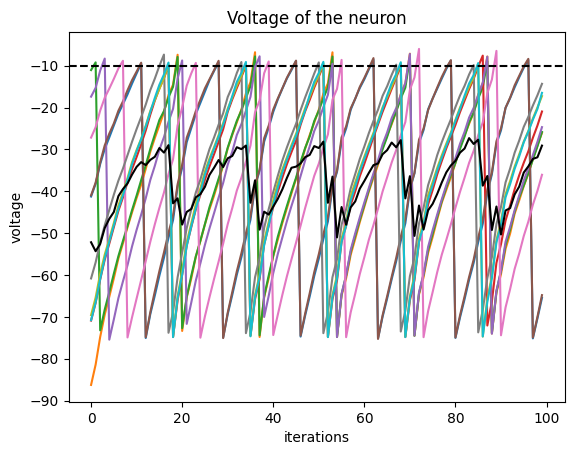

Text(0.5, 1.0, 'Input Current of LIF model')

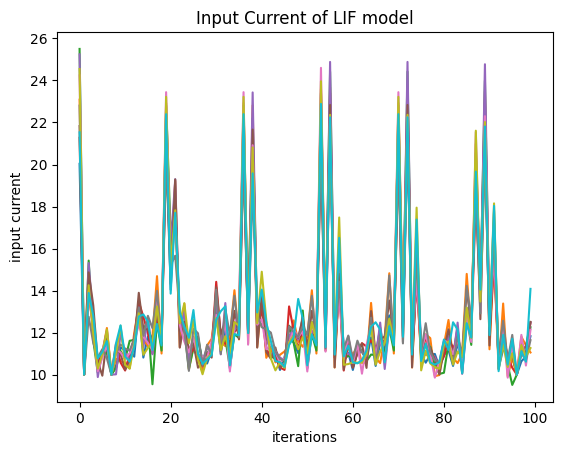

In [308]:
plt.plot(net['voltage', 0][:,0:10])
plt.plot(net['torch.mean(voltage)', 0], color='black')
plt.axhline(-10, color='black', linestyle='--')
# plt.axhline(ng['LIF_Behavior', 0].rh_threshold, color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('voltage')
plt.title('Voltage of the neuron')
plt.show()

plt.plot(net['I', 0][:,0:10])
plt.xlabel('iterations')
plt.ylabel('input current')
plt.title('Input Current of LIF model')

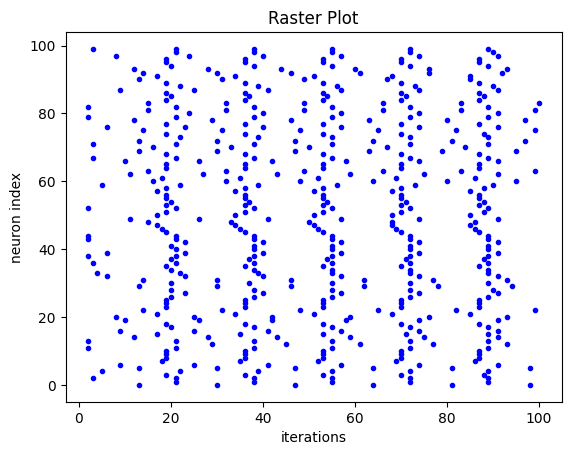

In [309]:
plt.plot(ng['spike.t', 0], ng['spike.i', 0], '.', color = "blue")
plt.xlabel('iterations')
plt.ylabel('neuron index')
plt.title('Raster Plot')
plt.show()

## Conductance-based Synapse Input

In [310]:
class SynVoltInp(Behavior) : 
    def forward(self, ng) : 
        ng.spike_train = ng.vector("zeros")
        for syn in ng.afferent_synapses["All"] : 
            ng.spike_train += syn.I

In [311]:
class SynVolt(Behavior) :

    def initialize(self, ng) : 
        self.E_ex = self.parameter("E_ex", -75)
        self.tau_syn = self.parameter("tau", 1.2)
        self.gE_bar = self.parameter("gE_bar", 0.03)

        ng.gt = sg.dst.vector("zeros")
        
        self.dt = 1

    def forward(self, ng) : 
        dG = -(ng.gt) / self.tau_syn + self.gE_bar * ng.spike_train
        ng.gt += dG * self.dt

        ng.I += ng.gt * (ng.voltage - self.E_ex)

In [316]:
net = Network()

ng = NeuronGroup(net = net, size = 100, behavior={
    1 : CurrentBehavior(mode = "constant", has_noise = False, pw = 10),
    3 : SynVoltInp(),
    4 : SynVolt(),
    5 : LIF_Behavior(tau = 25),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
    10 : EventRecorder(['spike'])
})

sg = SynapseGroup(net = net, src = ng, dst = ng, behavior={
    2 : SynFun()
})

In [317]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(10000)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){1:CurrentBehavior(mode=constant,has_noise=False,pw=10,)3:SynVoltInp()4:SynVolt()5:LIF_Behavior(tau=25,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S100xD100){2:SynFun(),}
100xBatch: 1/1 (100%) 138.630ms


C:\Users\Asus\AppData\Local\Temp\ipykernel_27128\3431504528.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  sg.I = torch.sum(sg.W[sg.src.spike], axis = 0)


138.62991333007812

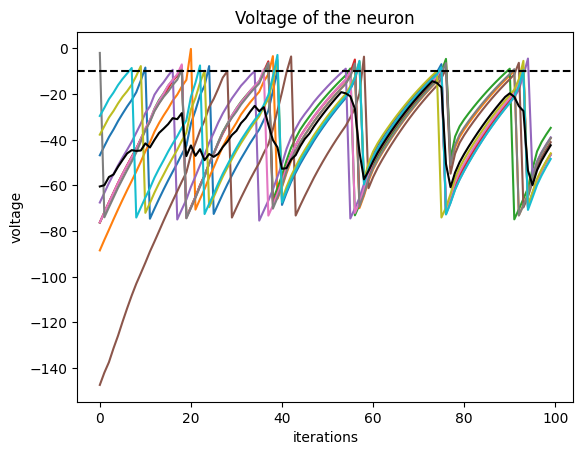

Text(0.5, 1.0, 'Input Current of LIF model')

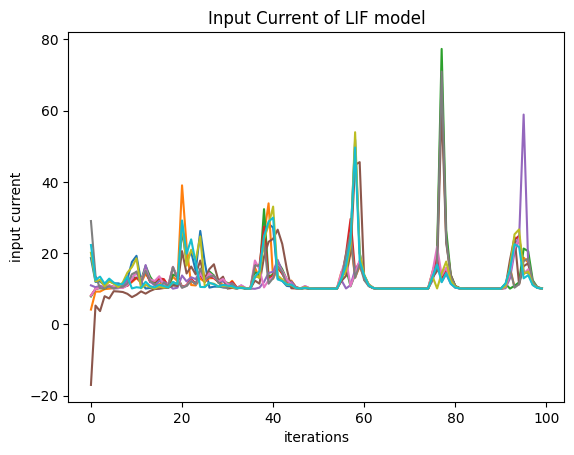

In [318]:
plt.plot(net['voltage', 0][:,0:10])
plt.plot(net['torch.mean(voltage)', 0], color='black')
plt.axhline(ng['LIF_Behavior', 0].threshold, color='black', linestyle='--')
# plt.axhline(ng['LIF_Behavior', 0].rh_threshold, color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('voltage')
plt.title('Voltage of the neuron')
plt.show()

plt.plot(net['I', 0][:,0:10])
plt.xlabel('iterations')
plt.ylabel('input current')
plt.title('Input Current of LIF model')

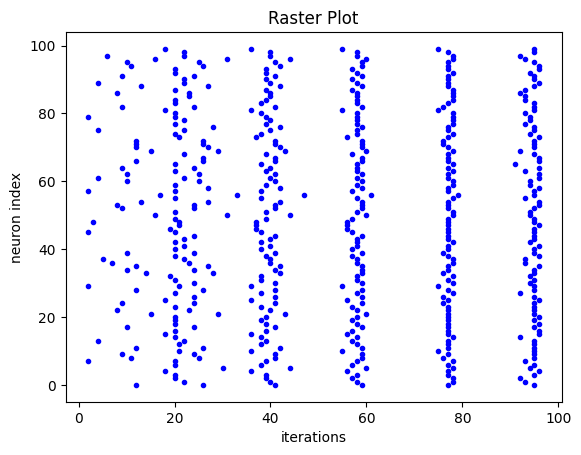

In [319]:
plt.plot(ng['spike.t', 0], ng['spike.i', 0], '.', color = "blue")
plt.xlabel('iterations')
plt.ylabel('neuron index')
plt.title('Raster Plot')
plt.show()

# Connectivity Scheme

In [8]:
import math

In [663]:
class SynConnectivity(Behavior) : 
    
    def initialize(self, sg) : 
        self.mode = self.parameter("mode", "full")
        self.J0 = self.parameter("J0", 50)
        self.n = self.parameter("size", 100)
        self.p = self.parameter("p", 0.3)
        self.C = self.parameter("C", 20)
        
        if(self.mode == "full") : 
            sg.W = sg.matrix(self.J0 / self.n)

        elif(self.mode == "full2") : 
            sg.W = sg.matrix("normal(1, 0.5)")

        elif(self.mode == "inh") : 
            sg.W = sg.matrix("normal(9, 3)")
        
        elif(self.mode == "random") : 
            sg.W = sg.matrix(self.J0 / (self.n * self.p))
            for i in range(sg.matrix_dim()[0]) : 
                for j in range(sg.matrix_dim()[1]) : 
                    q = random.random()
                    if(q > self.p) : 
                        sg.W[i, j] = 0

        elif(self.mode == "balanced") : 
            sg.W = sg.matrix(self.J0 / math.sqrt((self.n * self.p)))
            for i in range(sg.matrix_dim()[0]) : 
                for j in range(sg.matrix_dim()[1]) : 
                    q = random.random()
                    if(q > self.p) : 
                        sg.W[i, j] = 0

        elif(self.mode == "random_fixed") :
            sg.W = sg.matrix(self.J0 / self.n)
            for i in range(sg.matrix_dim()[0]) :
                adj = torch.randperm(sg.matrix_dim()[1])
                for j in range(self.C, sg.matrix_dim()[1]) : 
                    sg.W[i, adj[j]] = 0

        elif(self.mode == "balanced_fixed") : 
            md = "normal({}, {})".format(self.J0 / math.sqrt(self.C), self.J0 / math.sqrt(self.C) / 2)
            sg.W = sg.matrix(md)
            for i in range(sg.matrix_dim()[0]) :
                adj = torch.randperm(sg.matrix_dim()[1])
                for j in range(self.C, sg.matrix_dim()[1]) : 
                    sg.W[i, adj[j]] = 0            

In [1223]:
net = Network()

ng = NeuronGroup(net = net, size = 100, behavior={
    1 : CurrentBehavior(mode = "constant", has_noise = True, pw = 10),
    3 : SynInp(),
    6 : LIF_Behavior(tau = 25),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
    10 : EventRecorder(['spike'])
})

sg = SynapseGroup(net = net, src = ng, dst = ng, behavior={
    2 : SynConnectivity(
        mode = "random_fixed",
        C = 30,
        J0 = 40,
        p = 0.3
    ),
    3 : SynFun()
})

In [1224]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(10000)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){1:CurrentBehavior(mode=constant,has_noise=True,pw=10,)3:SynInp()6:LIF_Behavior(tau=25,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S100xD100){2:SynConnectivity(mode=random_fixed,C=30,J0=40,p=0.3,),3:SynFun(),}
100xBatch: 1/1 (100%) 65.861ms


C:\Users\Asus\AppData\Local\Temp\ipykernel_27128\1552661023.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  sg.I = torch.sum(sg.W[sg.src.spike], axis = 0)


65.86098670959473

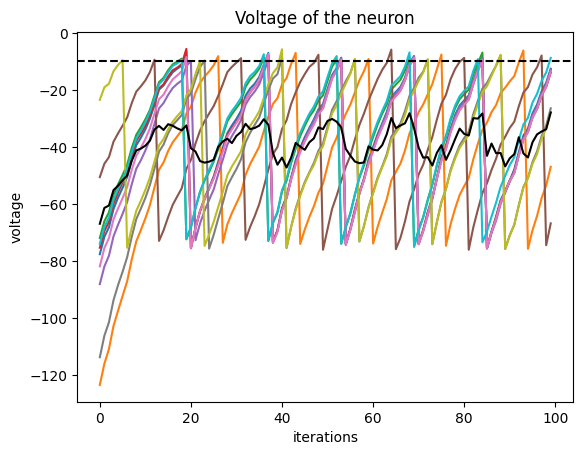

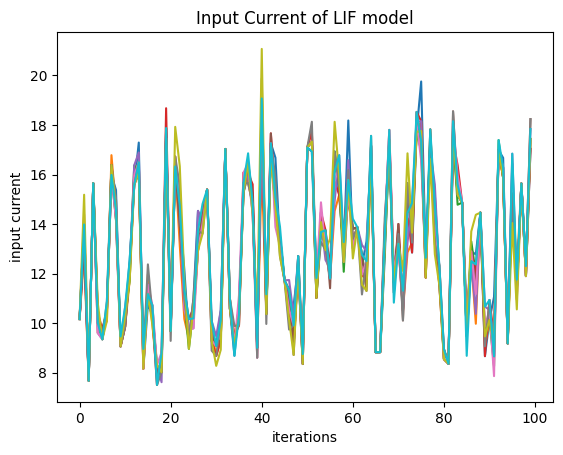

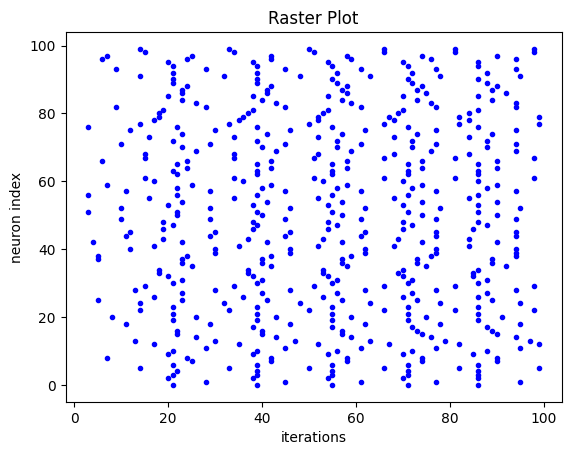

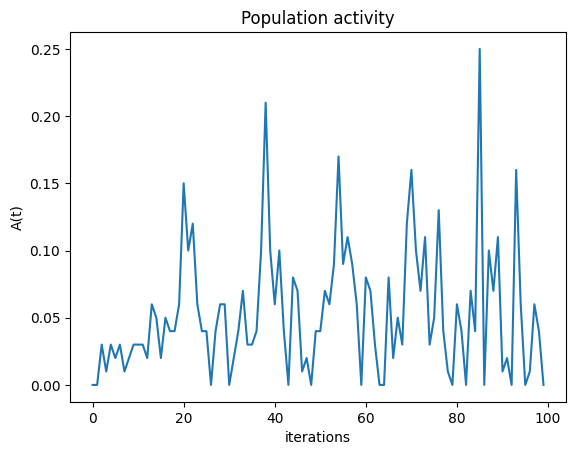

In [1225]:
plt.plot(net['voltage', 0][:,0:10])
plt.plot(net['torch.mean(voltage)', 0], color='black')
plt.axhline(ng['LIF_Behavior', 0].threshold, color='black', linestyle='--')
# plt.axhline(ng['LIF_Behavior', 0].rh_threshold, color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('voltage')
plt.title('Voltage of the neuron')
plt.show()

plt.plot(net['I', 0][:,0:10])
plt.xlabel('iterations')
plt.ylabel('input current')
plt.title('Input Current of LIF model')
plt.show()

plt.plot(ng['spike.t', 0], ng['spike.i', 0], '.', color = "blue")
plt.xlabel('iterations')
plt.ylabel('neuron index')
plt.title('Raster Plot')
plt.show()

plt.plot(net['activity', 0][:,0:1])
plt.xlabel('iterations')
plt.ylabel('A(t)')
plt.title('Population activity')
plt.show()

In [1226]:
net2 = Network()

ng2 = NeuronGroup(net = net2, size = 100, behavior={
    1 : CurrentBehavior(mode = "constant", has_noise = False, pw = 10),
    3 : SynInp(),
    6 : LIF_Behavior(tau = 25),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
    10 : EventRecorder(['spike'])
})

sg2 = SynapseGroup(net = net2, src = ng2, dst = ng2, behavior={
    2 : SynConnectivity(
        mode = "random_fixed",
        C = 30,
        J0 = 40,
        p = 0.3
    ),
    3 : SynFun()
})

In [1227]:
net2.initialize()
net2.simulate_iterations(100)

Network['Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(10000)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){1:CurrentBehavior(mode=constant,has_noise=False,pw=10,)3:SynInp()6:LIF_Behavior(tau=25,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S100xD100){2:SynConnectivity(mode=random_fixed,C=30,J0=40,p=0.3,),3:SynFun(),}
100xBatch: 1/1 (100%) 174.574ms


C:\Users\Asus\AppData\Local\Temp\ipykernel_27128\1552661023.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  sg.I = torch.sum(sg.W[sg.src.spike], axis = 0)


174.5736598968506

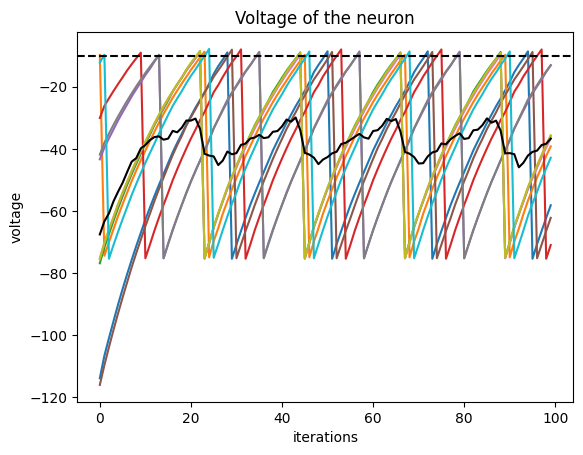

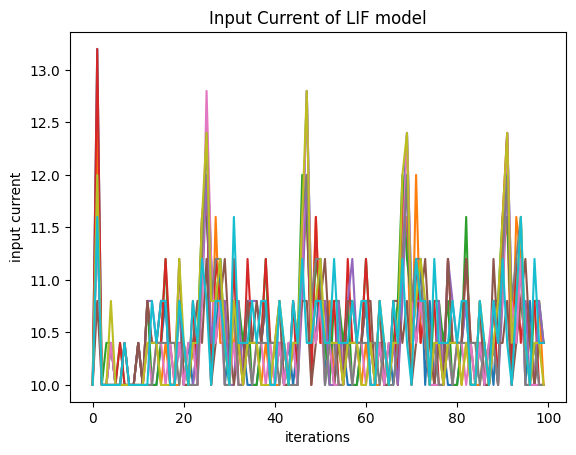

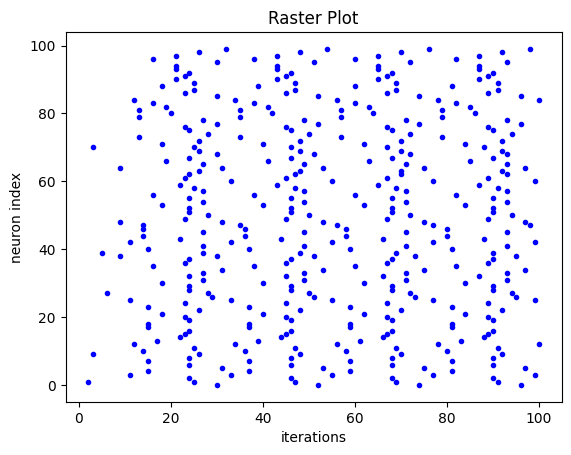

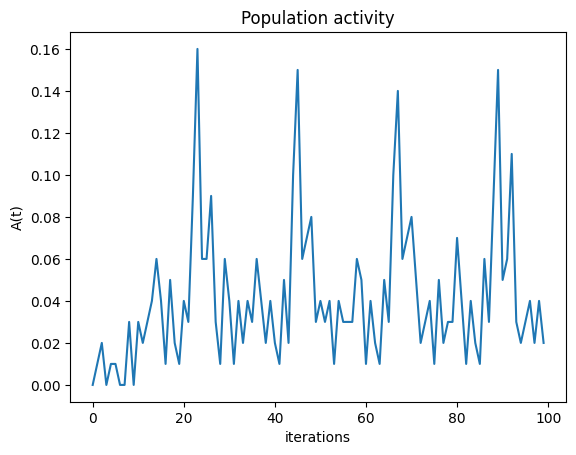

In [1228]:
plt.plot(net2['voltage', 0][:,0:10])
plt.plot(net2['torch.mean(voltage)', 0], color='black')
plt.axhline(ng2['LIF_Behavior', 0].threshold, color='black', linestyle='--')
# plt.axhline(ng['LIF_Behavior', 0].rh_threshold, color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('voltage')
plt.title('Voltage of the neuron')
plt.show()

plt.plot(net2['I', 0][:,0:10])
plt.xlabel('iterations')
plt.ylabel('input current')
plt.title('Input Current of LIF model')
plt.show()

plt.plot(ng2['spike.t', 0], ng2['spike.i', 0], '.', color = "blue")
plt.xlabel('iterations')
plt.ylabel('neuron index')
plt.title('Raster Plot')
plt.show()

plt.plot(net2['activity', 0][:,0:1])
plt.xlabel('iterations')
plt.ylabel('A(t)')
plt.title('Population activity')
plt.show()

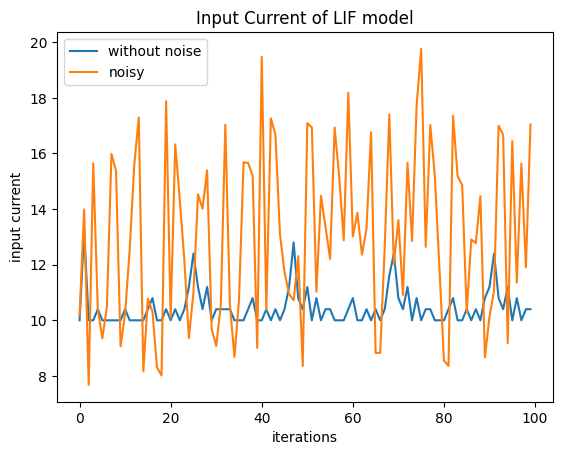

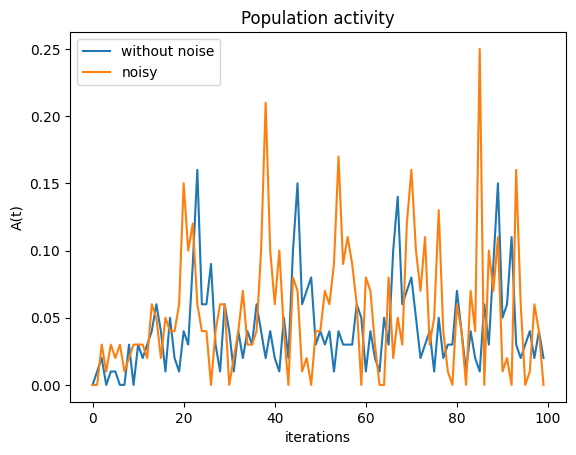

In [1229]:
plt.plot(net2['I', 0][:,0:1])
plt.plot(net['I', 0][:,0:1])

plt.xlabel('iterations')
plt.ylabel('input current')
plt.legend(["without noise", "noisy"])
plt.title('Input Current of LIF model')
plt.show()

plt.plot(net2['activity', 0][:,0:1])
plt.plot(net['activity', 0][:,0:1])
plt.xlabel('iterations')
plt.ylabel('A(t)')
plt.legend(["without noise", "noisy"])
plt.title('Population activity')
plt.show()

# Balanced Network

In [460]:
class SynTypeInput(Behavior) : 

    def forward(self, ng) : 
        for syn in ng.afferent_synapses["GLUTAMATE"] : 
            ng.I += syn.I
        
        for syn in ng.afferent_synapses["GABA"] : 
            ng.I -= syn.I

In [580]:
net = Network()

ng_ex = NeuronGroup(net = net, size = 80, behavior={
    1 : CurrentBehavior(mode = "constant", has_noise = False, pw = 10),
    4 : SynTypeInput(),
    6 : LIF_Behavior(tau = 25),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
    10 : EventRecorder(['spike'])
})

ng_in = NeuronGroup(net = net, size = 20, behavior={
    1 : CurrentBehavior(mode = "constant", has_noise = False, pw = 10),
    4 : SynTypeInput(),
    6 : LIF_Behavior(tau = 22),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
    10 : EventRecorder(['spike'])
})

SynapseGroup(net = net, src = ng_ex, dst = ng_ex, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "balanced_fixed", J0 = 30, C = 30),
    3 : SynFun()
})

SynapseGroup(net = net, src = ng_ex, dst = ng_in, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "balanced_fixed", J0 = 30, C = 30),
    3 : SynFun()
})

SynapseGroup(net = net, src = ng_in, dst = ng_ex, tag = "GABA", behavior={
    2 : SynConnectivity(mode = "balanced_fixed", J0 = 30, C = 30),
    3 : SynFun()
})

SynapseGroup(net = net, src = ng_in, dst = ng_in, tag = "GABA", behavior={
    2 : SynConnectivity(mode = "balanced_fixed", J0 = 30, C = 30),
    3 : SynFun()
})

SynapseGroup['GABA', 'SynapseGroup', 'syn', 'NeuronGroup_2 => NeuronGroup_2'](S20xD20){2:SynConnectivity(mode=balanced_fixed,J0=30,C=30,),3:SynFun(),}

In [581]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(100)|2 groups, Synapses: tensor(10000)|4 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](80){1:CurrentBehavior(mode=constant,has_noise=False,pw=10,)4:SynTypeInput()6:LIF_Behavior(tau=25,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](20){1:CurrentBehavior(mode=constant,has_noise=False,pw=10,)4:SynTypeInput()6:LIF_Behavior(tau=22,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S80xD80){2:SynConnectivity(mode=balance

C:\Users\Asus\AppData\Local\Temp\ipykernel_27128\1552661023.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  sg.I = torch.sum(sg.W[sg.src.spike], axis = 0)


132.6446533203125

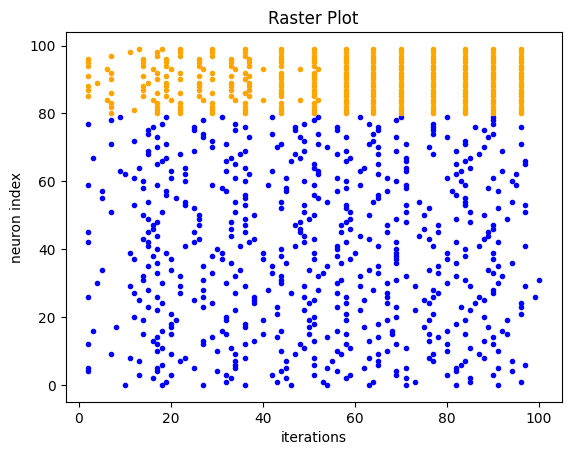

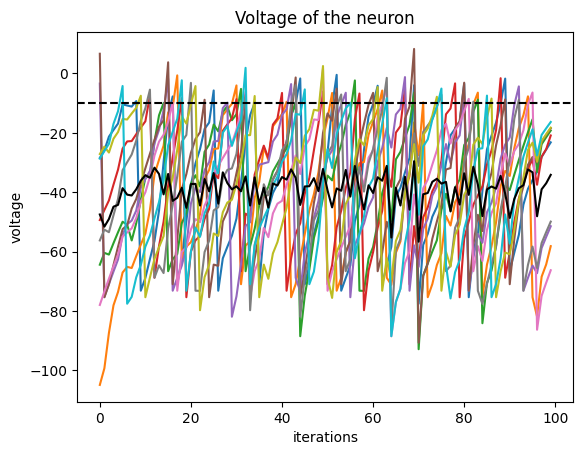

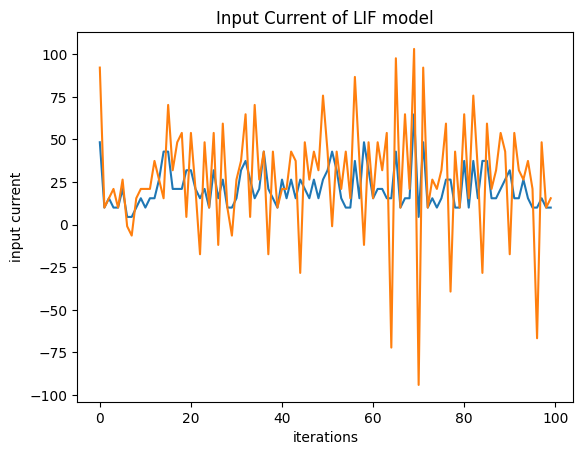

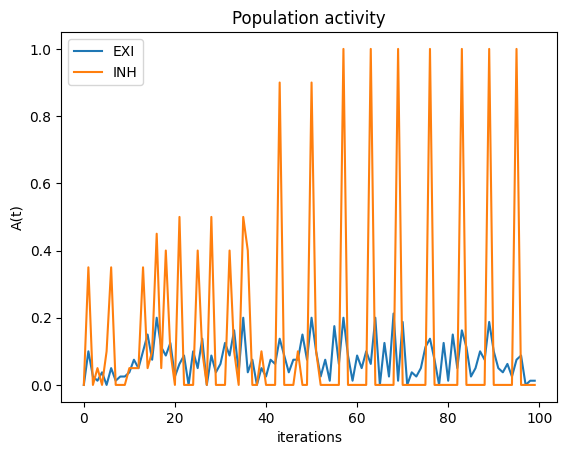

In [582]:
plt.plot(ng_ex['spike.t', 0], ng_ex['spike.i', 0], '.', color = "blue")
plt.plot(ng_in['spike.t', 0], ng_in['spike.i', 0] + 80, '.', color = "orange")
plt.xlabel('iterations')
plt.ylabel('neuron index')
plt.title('Raster Plot')
plt.show()

plt.plot(ng_ex['voltage', 0][:,0:10])
plt.plot(ng_ex['torch.mean(voltage)', 0], color='black')
plt.axhline(ng_ex['LIF_Behavior', 0].threshold, color='black', linestyle='--')
# plt.axhline(ng['LIF_Behavior', 0].rh_threshold, color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('voltage')
plt.title('Voltage of the neuron')
plt.show()

plt.plot(ng_ex['I', 0][:,0:1])
plt.plot(ng_in['I', 0][:,0:1])
plt.xlabel('iterations')
plt.ylabel('input current')
plt.title('Input Current of LIF model')
plt.show()


plt.plot(ng_ex['activity', 0][:,0:1])
plt.plot(ng_in['activity', 0][:,0:1])
plt.xlabel('iterations')
plt.ylabel('A(t)')
plt.title('Population activity')
plt.legend(["EXI", "INH"])
plt.show()

Text(0.5, 1.0, 'Input Current of LIF model')

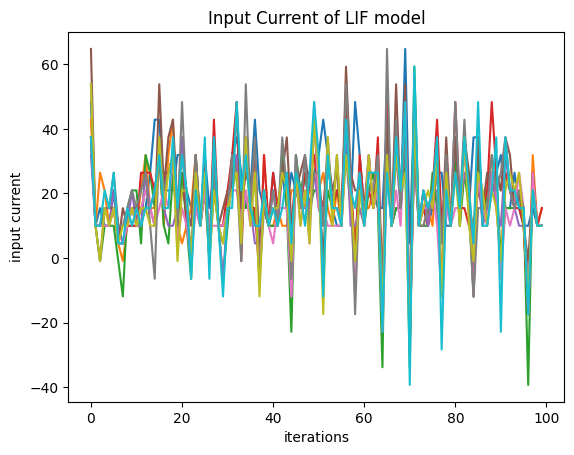

In [583]:
plt.plot(net['I', 0][:,:10])
plt.xlabel('iterations')
plt.ylabel('input current')
plt.title('Input Current of LIF model')

# Decision Making

In [608]:
class DecisionDynamic(Behavior) :

    def initialize(self, ng) : 
        self.h_tau = self.parameter("tau", 10) # inh : 2
        self.theta = self.parameter("theta", 25) # inh : 4
        self.h_R = self.parameter("R", 1) # inh : 4
        self.g_val = self.parameter("g_val", 4) # inh : 1
        self.gain = self.parameter("gain", 
            lambda x : (1 + torch.tanh((x - self.theta)/40)) * self.g_val/2
        )
        ng.h = ng.vector("zeros")
        ng.data = ng.vector("zeros")

    def forward(self, ng) :

        if(len(ng.efferent_synapses["GABA"]) == 0) : # EXI :
            
            inh = ng.afferent_synapses["GABA"][0]
            exi = ng.afferent_synapses["GLUTAMATE"][0]

            ng.data = inh.I * inh.src.DecisionDynamic.gain(ng.h)
            ng.data2 = inh.I
            
            dH = (-ng.h 
            + exi.I * self.gain(ng.h) 
            - inh.I * inh.src.DecisionDynamic.gain(inh.src.h)
            + self.h_R * ng.I
            ) / self.h_tau
        else : # INH
            exi1 = ng.afferent_synapses["GLUTAMATE"][0]
            exi2 = ng.afferent_synapses["GLUTAMATE"][1]

            dH = (-ng.h
            + exi1.I * exi1.src.DecisionDynamic.gain(exi1.src.h)
            + exi2.I * exi2.src.DecisionDynamic.gain(exi2.src.h)
            ) / self.h_tau
            
        ng.h += dH * 1 # dt
        ng.fuck_my_live = self.gain(ng.h)
        ng.voltage += self.gain(ng.h)

In [1348]:
net = Network()

ng_A = NeuronGroup(net = net, size = 80, tag = "EXI, EX1", behavior={
    1 : CurrentBehavior(mode = "change", has_noise = False, pw = 17),
    4 : SynTypeInput(),
    # 5 : DecisionDynamic(),
    6 : LIF_Behavior(tau = 25),
    # 7 : DecisionLIF(),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
    10 : EventRecorder(['spike'])
})

ng_B = NeuronGroup(net = net, size = 80, tag = "EXI, EX2", behavior={
    1 : CurrentBehavior(mode = "constant", has_noise = False, pw = 15),
    4 : SynTypeInput(),
    # 5 : DecisionDynamic(),
    6 : LIF_Behavior(tau = 25),
    # 7 : DecisionLIF(),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
    10 : EventRecorder(['spike'])
})

# ng_C = NeuronGroup(net = net, size = 80, tag = "EXI, EX3", behavior={
#     1 : CurrentBehavior(mode = "constant", has_noise = True, pw = 21),
#     4 : SynTypeInput(),
#     # 5 : DecisionDynamic(),
#     6 : LIF_Behavior(tau = 25),
#     # 7 : DecisionLIF(),
#     9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
#     10 : EventRecorder(['spike'])
# })

# ng_in = NeuronGroup(net = net, size = 40, tag = "INH", behavior={
#     1 : CurrentBehavior(mode = "constant", has_noise = False, pw = 0),
#     4 : SynTypeInput(),
#     # 5 : DecisionDynamic(gain = lambda x : 1.4 * x),
#     6 : LIF_Behavior(tau = 25),
#     # 7 : DecisionLIF(gain = lambda x : 4 * x),
#     9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
#     10 : EventRecorder(['spike'])
# })

SynapseGroup(net = net, src = ng_A, dst = ng_A, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 40),
    3 : SynFun()
})

SynapseGroup(net = net, src = ng_B, dst = ng_B, tag = "GLUTAMATE", behavior={
    2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 40),
    3 : SynFun()
})

# SynapseGroup(net = net, src = ng_C, dst = ng_C, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 40),
#     3 : SynFun()
# })

# -------------------------------------------------------------------------

# SynapseGroup(net = net, src = ng_A, dst = ng_in, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 20),
#     3 : SynFun()
# })

# SynapseGroup(net = net, src = ng_B, dst = ng_in, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 20),
#     3 : SynFun()
# })

# SynapseGroup(net = net, src = ng_C, dst = ng_in, tag = "GLUTAMATE", behavior={
#     2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 20),
#     3 : SynFun()
# })
# -------------------------------------------------------------------------

# SynapseGroup(net = net, src = ng_in, dst = ng_A, tag = "GABA", behavior={
#     2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 25),
#     3 : SynFun()
# })

# SynapseGroup(net = net, src = ng_in, dst = ng_B, tag = "GABA", behavior={
#     2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 25),
#     3 : SynFun()
# })

# -------------------------------------------------------------------------

SynapseGroup(net = net, src = ng_A, dst = ng_B, tag = "GABA", behavior={
    2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 7),
    3 : SynFun()
})

SynapseGroup(net = net, src = ng_B, dst = ng_A, tag = "GABA", behavior={
    2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 7),
    3 : SynFun()
})

# ---------------------------------------
# (INH-INH) CONNECTION
# SynapseGroup(net = net, src = ng_in, dst = ng_in, tag = "GABA", behavior={
#     2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 25),
#     3 : SynFun()
# })
# ---------------------------------------

# SynapseGroup(net = net, src = ng_in, dst = ng_C, tag = "GABA", behavior={
#     2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 25),
#     3 : SynFun()
# })


SynapseGroup['GABA', 'SynapseGroup', 'syn', 'EXI => EXI'](S80xD80){2:SynConnectivity(mode=balanced_fixed,C=30,J0=7,),3:SynFun(),}

In [1349]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(160)|2 groups, Synapses: tensor(25600)|4 groups){}
NeuronGroup['EXI', 'EX1', 'NeuronGroup', 'ng'](80){1:CurrentBehavior(mode=change,has_noise=False,pw=17,)4:SynTypeInput()6:LIF_Behavior(tau=25,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
NeuronGroup['EXI', 'EX2', 'NeuronGroup', 'ng'](80){1:CurrentBehavior(mode=constant,has_noise=False,pw=15,)4:SynTypeInput()6:LIF_Behavior(tau=25,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'EXI => EXI'](S80xD80){2:SynConnectivity(mode=balanced_fixed,C=30,J0=40,),3:SynFu

C:\Users\Asus\AppData\Local\Temp\ipykernel_27128\1552661023.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  sg.I = torch.sum(sg.W[sg.src.spike], axis = 0)


168.50757598876953

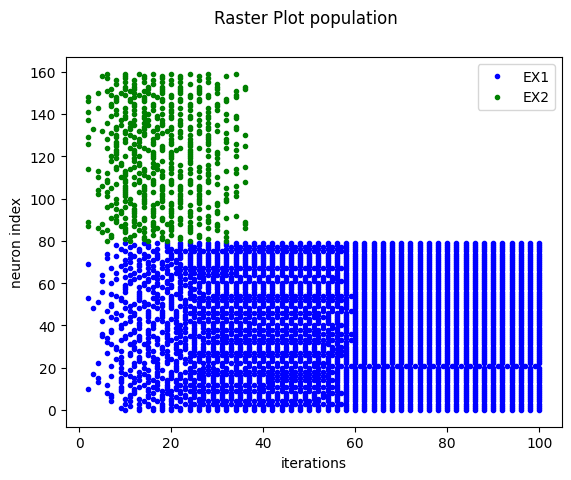

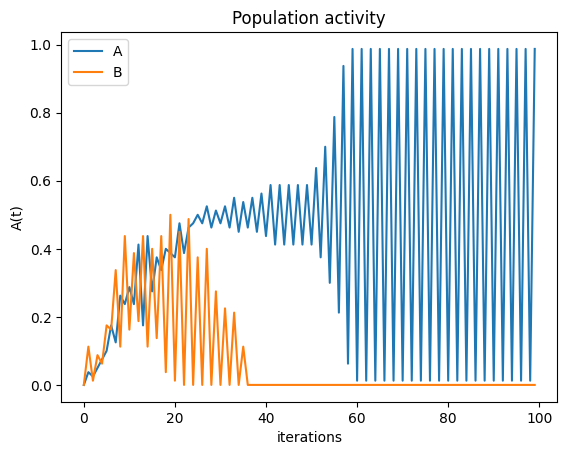

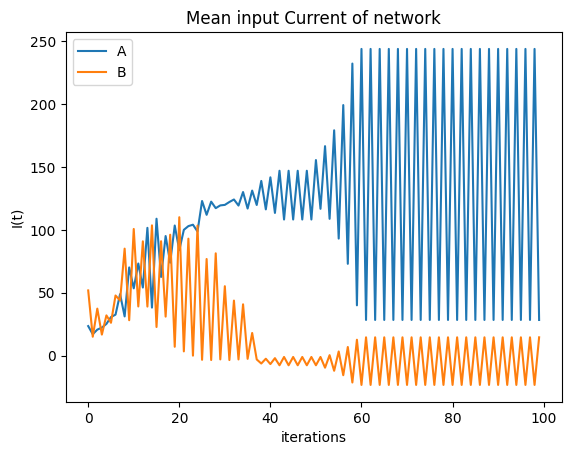

In [1350]:
fig, (ax1) = plt.subplots(1, 1)
fig.suptitle('Raster Plot population')
# fig.set_figwidth()

ax1.plot(ng_A['spike.t', 0], ng_A['spike.i', 0], '.', color = "blue")
ax1.plot(ng_B['spike.t', 0], ng_B['spike.i', 0] + 80, '.', color = "green")
# ax1.plot(ng_C['spike.t', 0], ng_C['spike.i', 0] + 160, '.', color = "red")
# ax1.plot(ng_in['spike.t', 0], ng_in['spike.i', 0] + 160, '.', color = "orange")

ax1.legend(["EX1", "EX2"], loc = 'upper right')

ax1.set(xlabel = 'iterations', ylabel = 'neuron index')
plt.show()

plt.plot(ng_A['activity', 0][:,0:1])
plt.plot(ng_B['activity', 0][:,0:1])
# plt.plot(ng_C['activity', 0][:,0:1])

# plt.plot(ng_in['activity', 0][:,0:1])
plt.xlabel('iterations')
plt.ylabel('A(t)')
plt.title('Population activity')
plt.legend(["A", "B"])
plt.show()


plt.plot(torch.sum(ng_A['I', 0][:], axis = 1)/ng_A.size)
plt.plot(torch.sum(ng_B['I', 0][:], axis = 1)/ng_B.size)
plt.xlabel('iterations')
plt.ylabel('I(t)')
plt.title('Mean input Current of network')
plt.legend(["A", "B", "C"])
plt.show()

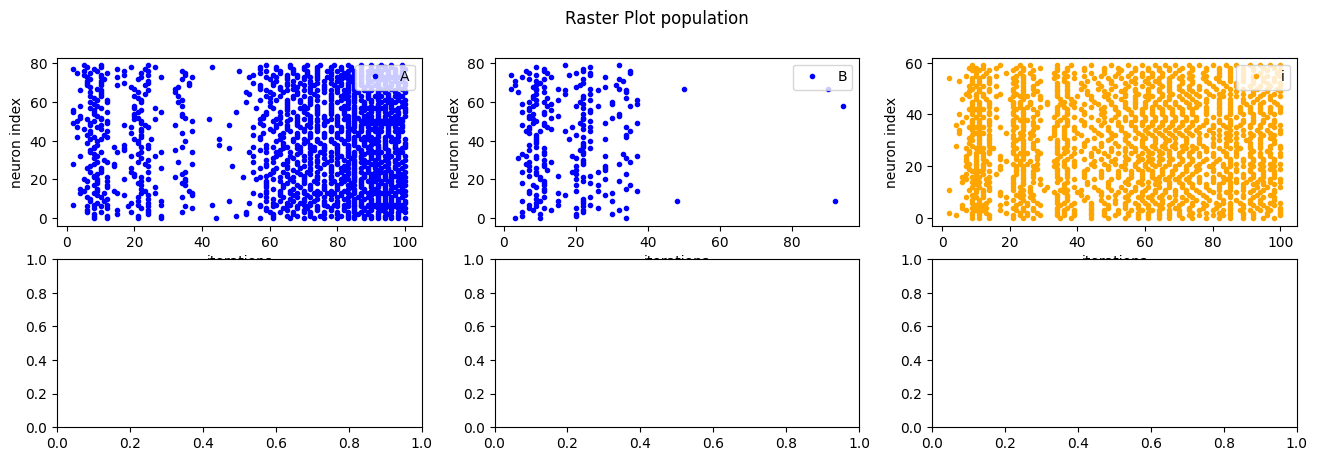

In [960]:
fig, ax = plt.subplots(2, 3)
fig.suptitle('Raster Plot population')
fig.set_figwidth(16)

ax[0, 0].plot(ng_A['spike.t', 0], ng_A['spike.i', 0], '.', color = "blue")
ax[0, 0].legend('A exi', loc = 'upper right')
ax[0, 0].set(xlabel = 'iterations', ylabel = 'neuron index')

ax[0, 1].plot(ng_B['spike.t', 0], ng_B['spike.i', 0], '.', color = "blue")
ax[0, 1].legend("B exi", loc = 'upper right')
ax[0, 1].set(xlabel = 'iterations', ylabel = 'neuron index')

ax[0, 2].plot(ng_in['spike.t', 0], ng_in['spike.i', 0], '.', color = "orange")
ax[0, 2].legend("inh-spike-pattern", loc = 'upper right')
ax[0, 2].set(xlabel = 'iterations', ylabel = 'neuron index')

# ax[1, 0].plot(ng_A['fuck_my_live', 0])
# ax[1, 1].plot(ng_B['fuck_my_live', 0])
# ax[1, 2].plot(ng_in['fuck_my_live', 0])

plt.show()

In [983]:
for ng in net.NeuronGroups :
    if("INH" not in ng.tags) : 
        print(ng)

NeuronGroup['EXI', 'EX1', 'NeuronGroup', 'ng'](80){1:CurrentBehavior(mode=change,has_noise=True,pw=22,)4:SynTypeInput()6:LIF_Behavior(tau=25,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
NeuronGroup['EXIb', 'EX2', 'NeuronGroup', 'ng'](80){1:CurrentBehavior(mode=constant,has_noise=True,pw=18,)4:SynTypeInput()6:LIF_Behavior(tau=25,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
NeuronGroup['EXIc', 'EX3', 'NeuronGroup', 'ng'](80){1:CurrentBehavior(mode=constant,has_noise=True,pw=20,)4:SynTypeInput()6:LIF_Behavior(tau=25,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True

In [1003]:
ng_A['activity', 0][:,0:1][1].item()

0.0625

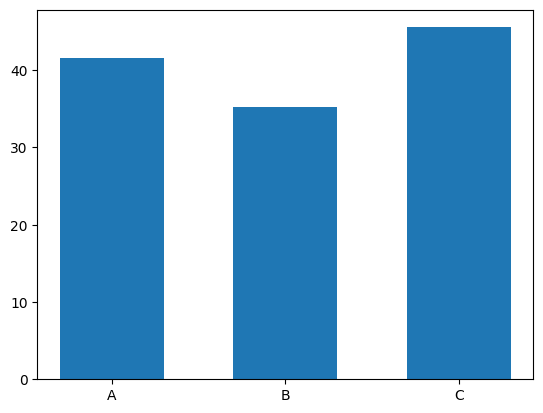

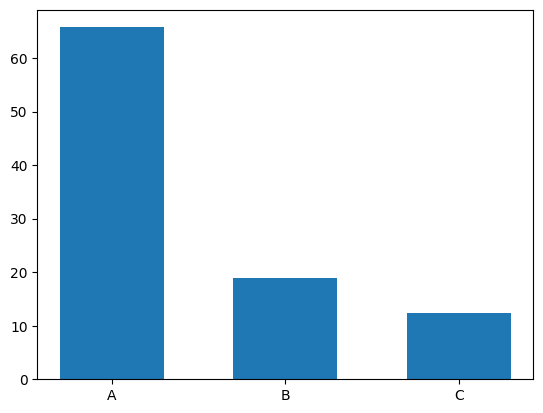

In [1007]:
I_st = []
for ng in net.NeuronGroups : 
    if("INH" not in ng.tags) : 
        I_st.append((torch.sum(ng['I', 0][:], axis = 1)/ng.size)[0])

I_en = []
for ng in net.NeuronGroups : 
    if("INH" not in ng.tags) : 
        I_en.append((torch.sum(ng['I', 0][:], axis = 1)/ng.size)[-1])

plt.bar(["A", "B", "C"], height=I_st, width=0.6)
plt.show()

plt.bar(["A", "B", "C"], height=I_en, width=0.6)
plt.show()

0.0625
0.05000000074505806
0.0625
0.737500011920929
0.0
0.0


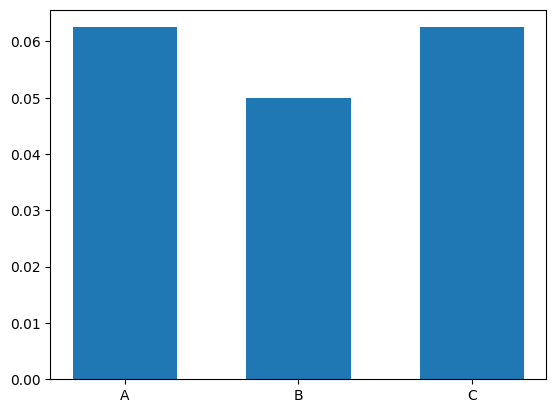

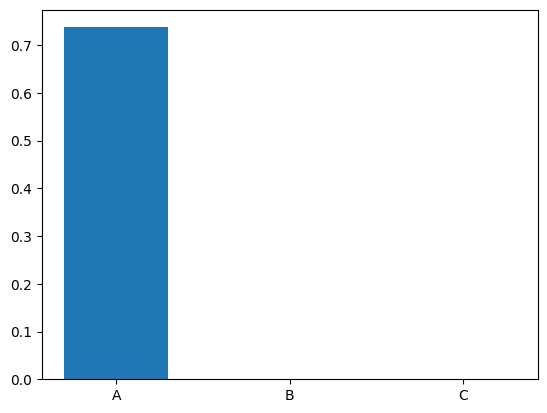

In [1006]:
act_st = []
for ng in net.NeuronGroups : 
    if("INH" not in ng.tags) :
        I_st.append(ng['activity', 0][:,0:1][1].item())

act_en = []
for ng in net.NeuronGroups : 
    if("INH" not in ng.tags) : 
        I_en.append(ng['activity', 0][:,0:1][-1].item())

plt.bar(["A", "B", "C"], height=act_st, width=0.6)
plt.show()

plt.bar(["A", "B", "C"], height=act_en, width=0.6)
plt.show()

In [1026]:
N = Network()
NG = NeuronGroup(net = N, size = 100, behavior={})
sgg = SynapseGroup(net = N, src = NG, dst = NG)
sgg.W = sgg.matrix(mode = "random")
p = 0.4
sgg.W[:][sgg.W < 1]
# sgg.W[sgg.W >= p] 

# J0 = 50
# N = 100
# sgg.W = sgg.W * sgg.matrix(J0 / (N*p))

tensor([0.2551, 0.3642, 0.0429,  ..., 0.3313, 0.2132, 0.1375])

In [1031]:
torch.randint(15, 25, (8,))

tensor([24, 15, 23, 22, 15, 22, 23, 23])

# Generalized Winnder-takes-all network

In [1112]:
net = Network()

k = 8
I_init = torch.randint(15, 22, (k,))

target = 2
I_init[target] = 24

ngs = []
for i in range(k) : 
    md = "constant"
    if(i == target) : 
        md = "change"

    ng = NeuronGroup(net = net, size = 80, tag = "EX{}".format(i + 1), behavior={
        1 : CurrentBehavior(mode = md, has_noise = True, pw = I_init[i].item()),
        4 : SynTypeInput(),
        # 5 : DecisionDynamic(),
        6 : LIF_Behavior(tau = 25),
        # 7 : DecisionLIF(),
        9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
        10 : EventRecorder(['spike'])
    })

    ngs.append(ng)

ng_in = NeuronGroup(net = net, size = k * 20, tag = "INH", behavior={
    1 : CurrentBehavior(mode = "constant", has_noise = False, pw = 0),
    4 : SynTypeInput(),
    # 5 : DecisionDynamic(gain = lambda x : 1.4 * x),
    6 : LIF_Behavior(tau = 25),
    # 7 : DecisionLIF(gain = lambda x : 4 * x),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'activity']),
    10 : EventRecorder(['spike'])
})

for i in range(k) : 
    SynapseGroup(net = net, src = ngs[i], dst = ngs[i], tag = "GLUTAMATE", behavior={
        2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 40),
        3 : SynFun()
    })

    SynapseGroup(net = net, src = ngs[i], dst = ng_in, tag = "GLUTAMATE", behavior={
        2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 20),
        3 : SynFun()
    })

    SynapseGroup(net = net, src = ng_in, dst = ngs[i], tag = "GABA", behavior={
        2 : SynConnectivity(mode = "balanced_fixed", C = 30, J0 = 25),
        3 : SynFun()
    })

In [1113]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(800)|9 groups, Synapses: tensor(256000)|24 groups){}
NeuronGroup['EX1', 'NeuronGroup', 'ng'](80){1:CurrentBehavior(mode=constant,has_noise=True,pw=16,)4:SynTypeInput()6:LIF_Behavior(tau=25,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
NeuronGroup['EX2', 'NeuronGroup', 'ng'](80){1:CurrentBehavior(mode=constant,has_noise=True,pw=21,)4:SynTypeInput()6:LIF_Behavior(tau=25,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'activity'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
NeuronGroup['EX3', 'NeuronGroup', 'ng'](80){1:CurrentBehavior(mode=change,has_noise=True,pw=24,)4:SynTypeInput()6:LIF_Behavior(tau=25,)9:Recor

C:\Users\Asus\AppData\Local\Temp\ipykernel_27128\1552661023.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  sg.I = torch.sum(sg.W[sg.src.spike], axis = 0)


100xBatch: 1/1 (100%) 777.920ms


777.9195308685303

'B'

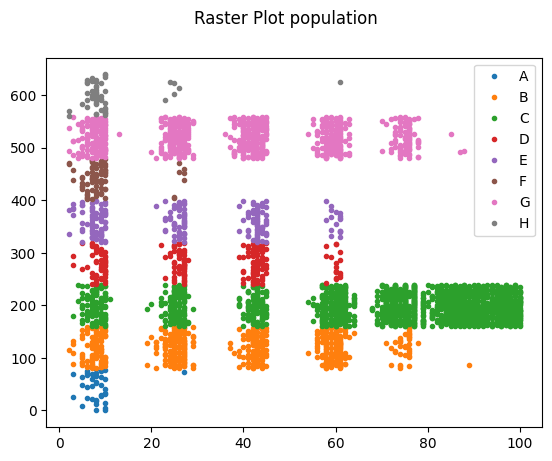

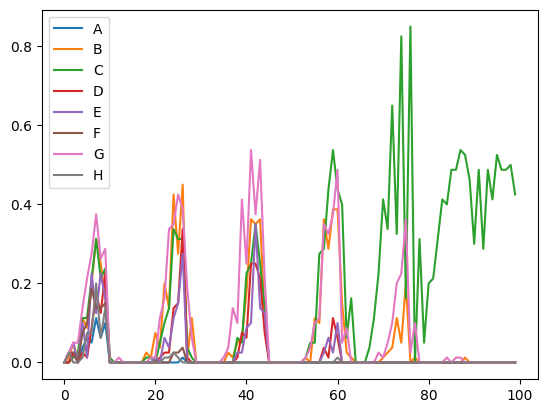

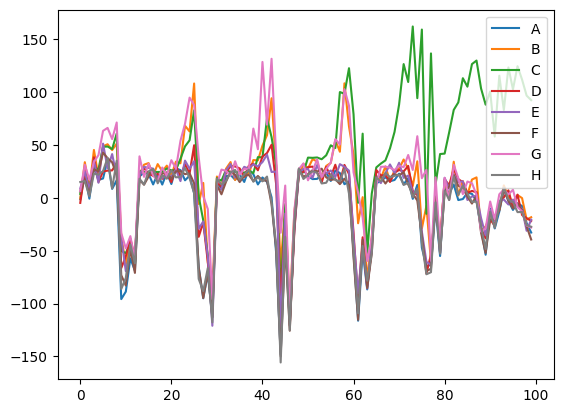

In [1133]:
fig, (ax1) = plt.subplots(1, 1)
fig.suptitle('Raster Plot population')
# fig.set_figwidth()

lgd = []
for i in range(k) : 
    ax1.plot(net.NeuronGroups[i]['spike.t', 0], net.NeuronGroups[i]['spike.i', 0] + (i * 80), '.')
    lgd.append(chr(ord('A') + i))

plt.legend(lgd)
plt.show()

for i in range(k) : 
    plt.plot(net.NeuronGroups[i]['activity', 0][:,0:1])

plt.legend(lgd)
plt.show()

for i in range(k) : 
    plt.plot(torch.sum(net.NeuronGroups[i]['I', 0][:], axis = 1)/net.NeuronGroups[i].size)

plt.legend(lgd)
plt.show()

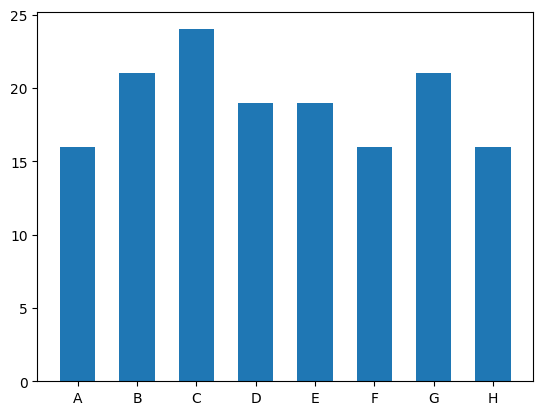

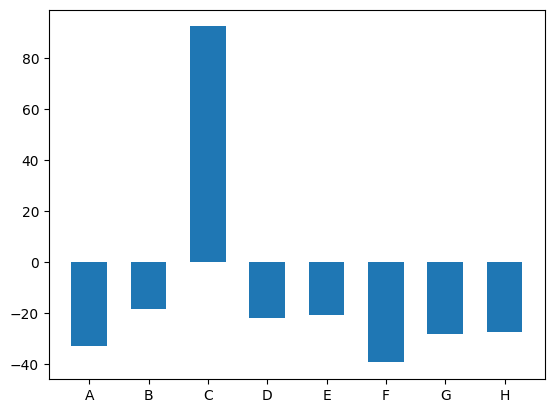

In [1138]:
I_st = []
for ng in net.NeuronGroups : 
    if("INH" not in ng.tags) : 
        I_st.append((torch.sum(ng['I', 0][:], axis = 1)/ng.size)[0])

I_en = []
for ng in net.NeuronGroups : 
    if("INH" not in ng.tags) : 
        I_en.append((torch.sum(ng['I', 0][:], axis = 1)/ng.size)[-1])

plt.bar(lgd, height=I_init, width=0.6)
plt.show()

plt.bar(lgd, height=I_en, width=0.6)
plt.show()

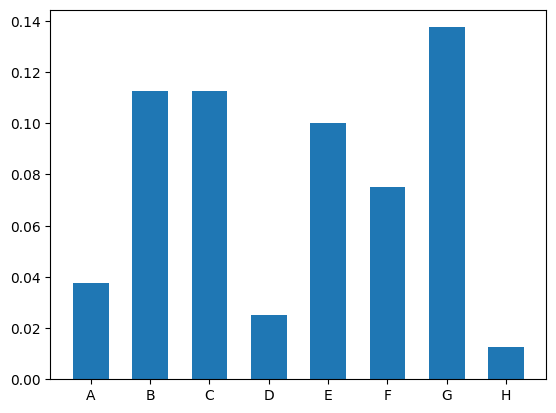

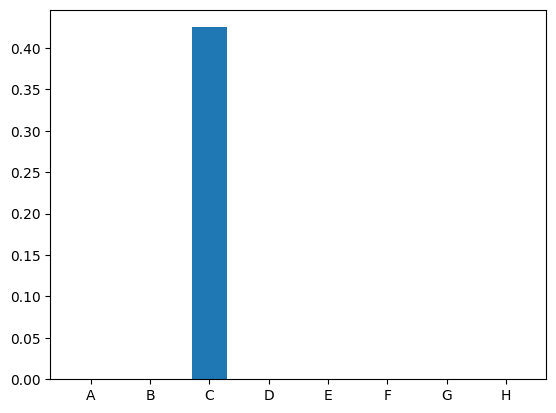

In [1147]:
act_st = []
for ng in net.NeuronGroups : 
    if("INH" not in ng.tags) :
        act_st.append(ng['activity', 0][:,0:1][4].item())

act_en = []
for ng in net.NeuronGroups : 
    if("INH" not in ng.tags) : 
        act_en.append(ng['activity', 0][:,0:1][-1].item())

plt.bar(lgd, height=act_st, width=0.6)
plt.show()

plt.bar(lgd, height=act_en, width=0.6)
plt.show()